# Introduction to DCP haze removal algorithm
___

## Define Algorhms used by DCP

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def image_rotate(image,anti_clockwise=True):
    h,w,c = image.shape
    temp = np.zeros([w,h,c],np.uint8)
    if anti_clockwise:
        for i in range(h):
            for j in range(w):
                temp[w-j-1,i,:] = image[i,j,:]
        return temp
    else:
        for i in range(h):
            for j in range(w):
                temp[j,h-i-1,:] = image[i,j,:]
        return temp
    
def get_atmosphere(image,dark_channel):
    m,n = dark_channel.shape
    n_pixel = m*n
    dark_vec = dark_channel.reshape(n_pixel)
    image_vec = image.reshape(n_pixel,3)
    indices = np.argsort(dark_vec)
    return np.mean(image_vec[indices[-int(np.floor(0.01*n_pixel)):],:],0)

def get_transmition(image,atmosphere,t0):
    transmition = 1 - omega*np.min(np.true_divide(img,atmosphere),2)
    transmition[transmition<t0] = t0
    return transmition

def get_radiance(image,atmosphere,transmition):
    radiance = np.true_divide(img-atmosphere,np.tile(transmition.reshape([img.shape[0],img.shape[1],1]),(1,1,3)))+atmosphere
    radiance[radiance>255] = 255
    radiance[radiance<0] = 0
    return np.uint8(radiance)

def dehaze(image,omega = 0.95,t0 = 0.1):
#     image = np.float64(image)
    dark_channel = np.min(image,2)
    atmosphere = get_atmosphere(image,dark_channel)
    transmition = get_transmition(image,atmosphere,t0)
    return get_radiance(image,atmosphere,transmition)

## Load and Show Test Image

In [2]:
# forest.jpg canon3.bmp foggyHouse.jpg test.png tiananmen.png tree.png
img_name = "forest.jpg"
path = "image/"
output_path = "image/output"

img = cv2.imread(path+img_name)
if img.shape[0]>img.shape[1]:
    img = image_rotate(img,True)

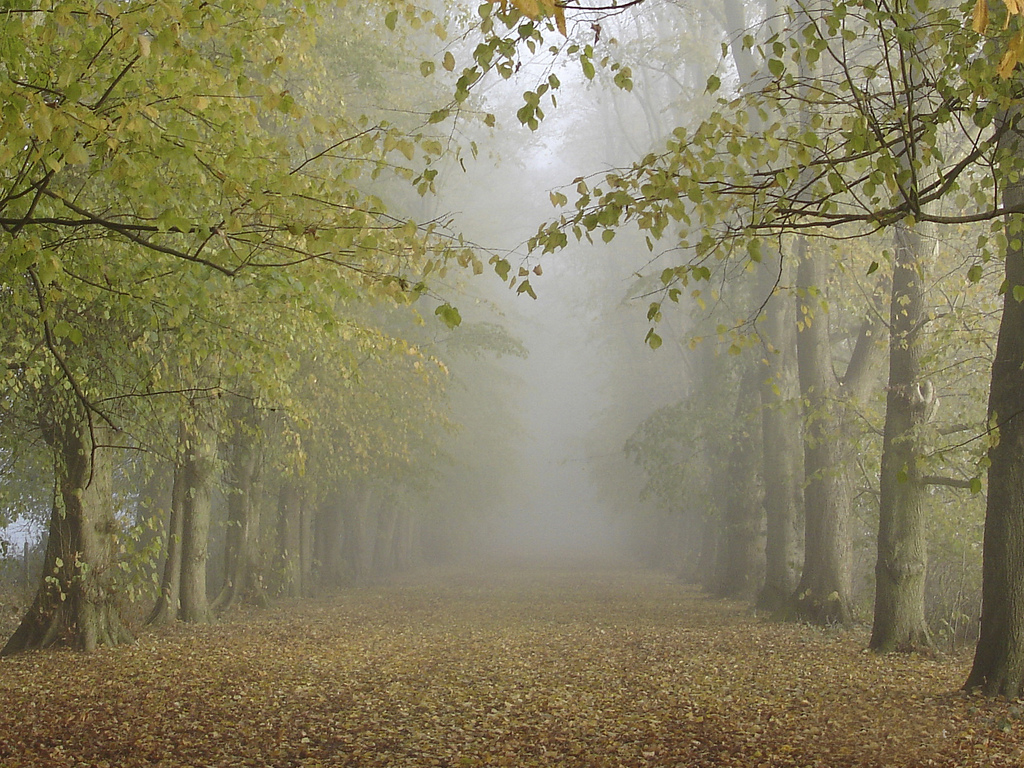

In [8]:
from PIL import Image
img_name = "forest.jpg"
path = "image/"
im= Image.fromarray(img[:,:,[2,1,0]])
im

## DCP haze removal algorithm (without filtering)
click [here](https://mmlab.ie.cuhk.edu.hk/pdf/Single%20Image%20Haze%20Removal%20Using%20Dark%20Channel%20Prior.pdf) to check the paper

In [31]:
import time
omega = 0.85 # dehazing intensity
t0 = 0.1     # minimum transmission

start = time.time()
radiance = dehaze(img,omega,t0)
end = time.time()
t_ori = end - start
print("Required time:" + str(t_ori))

Required time:2.746265411376953


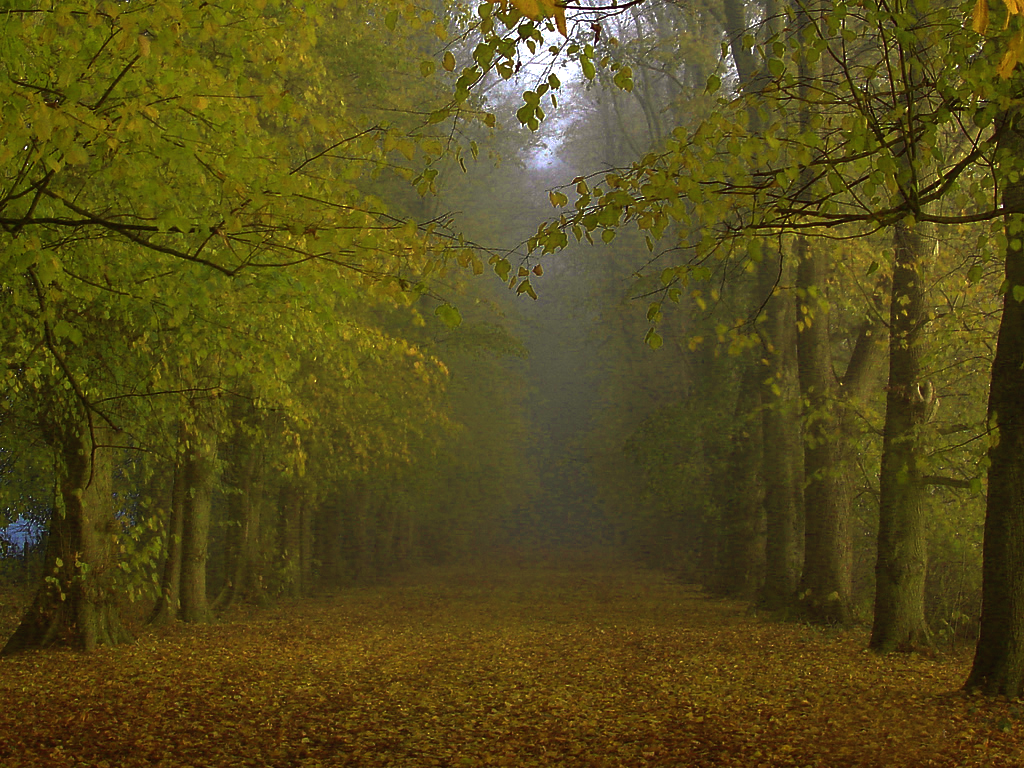

In [32]:
Image.fromarray(radiance[:,:,[2,1,0]])

# Simplified DCP algorithm for acceleration
This algorithm is propose by author and is very efficent for hardware implementation

In [36]:
a = 0.15 # atmosphere reduction ratio & minimum transmissiion

start = time.time()

dark_channel = np.min(img,2)
atmosphere = (1-a)*img[np.where(dark_channel == np.max(dark_channel))][0]
# /255 >> 右移7位 （不需要可配置）
transmition = 1 - dark_channel/255 # /255 >> right shift 7 bit
transmition[transmition<a] = a
radiance = get_radiance(img,atmosphere,transmition)

end = time.time()
t_fast = end - start
print("Required time: " + str(t_fast))
print("Acceleration ratio: " + str(t_ori/t_fast))

Required time: 1.3914501667022705
Acceleration ratio: 1.9736714092216379


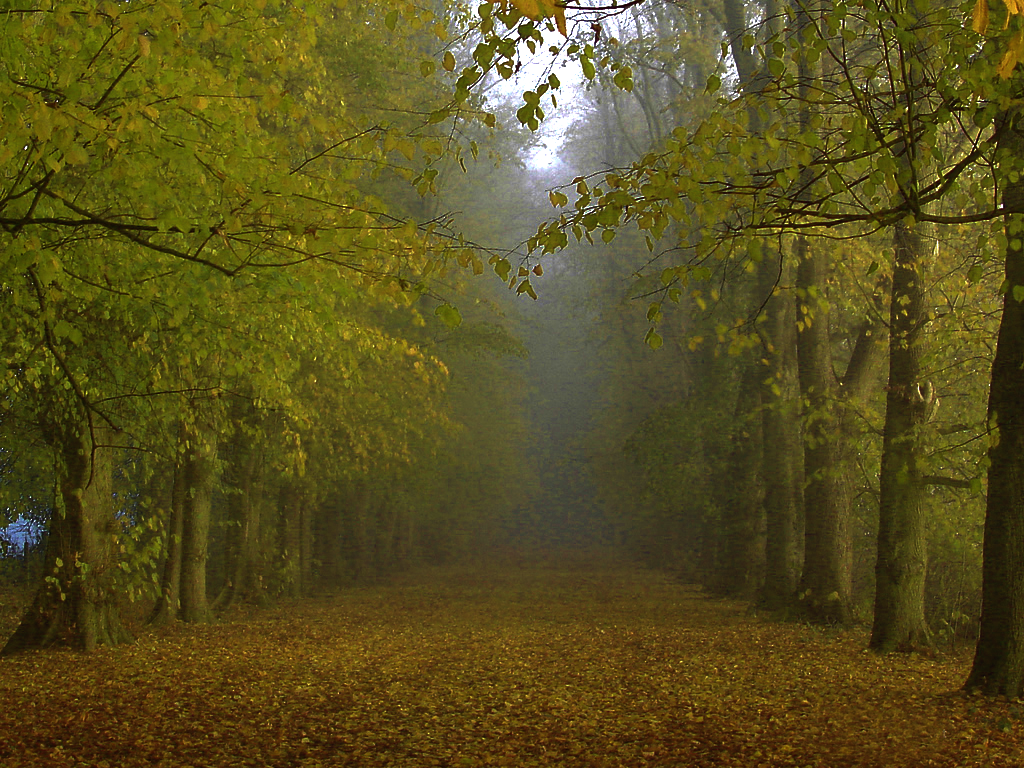

In [37]:
Image.fromarray(radiance[:,:,[2,1,0]])

## Conclusion
Next, we will use the simplified one to process HDMI video stream